## Spectra of weight matrices

We plot the singular values of the weight matrices of networks. If a layer has a lot of duplicates, then that layer's weight matrix should have a low rank. This rank can be observed as a sharp drop in the singular value spectrum of the weight matrix.

### Settings

In [1]:
import os
import torch
import torchvision
import json
import numpy as np
import matplotlib as plt
from vis_utils import *
from model_def import *
from model_train import *
from net_reduce import *

plt.rcParams.update({'font.size': 20})

%matplotlib inline

In [67]:
def plot_svd_spectra(net, param_names, outDir):
    param_dict = net.state_dict()
    
    for p_name in param_names:
        w = param_dict[p_name]
        w = w.numpy()
        sz = w.shape
        print sz
        # reshape for conv kernels
        if not len(sz) == 2:
            w = np.reshape(w, (sz[0],-1))
            U, S, V = np.linalg.svd(w, full_matrices=True)
        else:
            U, S, V = np.linalg.svd(w)
        
        # %-variance explained by each singular value
        sum_s = np.sum(S)
        S = S/sum_s * 100
        
        # percentile
        cum_sum = np.cumsum(S)
        prcnt_index = np.where(cum_sum>=99)
        prcnt_95 = np.where(cum_sum>=95)
        print prcnt_index[0][0]
        
        f = plt.figure()
        # plt.rcParams.update(plt.rcParamsDefault)
        plt.bar(range(len(S)),S)
        plt.xlabel('Singular values')
        if sz[0] == 100: # HACK
            plt.ylabel('Percentage of energy')
        plt.title('fc1: %d ' % (sz[0]) )
        
        plt.axvline(x=prcnt_index[0][0], color='r', linestyle='--')
        # plt.axvline(x=prcnt_95[0][0], color='k', linestyle='--')
        
        f.savefig(os.path.join(outDir,'singular-values-percent-%s.pdf' % p_name), bbox_inches='tight')
        f.savefig(os.path.join(outDir,'singular-values-percent-%s.png' % p_name), bbox_inches='tight')


In [3]:
def get_svd_spectra(net, param_names):
    param_dict = net.state_dict()
    spectra = []
    
    for p_name in param_names:
        w = param_dict[p_name]
        w = w.numpy()
        sz = w.shape
        print sz
        # reshape for conv kernels
        if not len(sz) == 2:
            w = np.reshape(w, (sz[0],-1))
            U, S, V = np.linalg.svd(w, full_matrices=True)
        else:
            U, S, V = np.linalg.svd(w)
        spectra.append(S)
    return spectra

In [4]:
def get_filter_groups(net, LAYER_CURR, SIMIL_THRESH):
    # threshold filter similarity and get conn-comps
    similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight')
    adj_mat = np.greater(similMat, SIMIL_THRESH)
    cc_list, n_comps = get_adjmat_conn_comp(adj_mat)
    return cc_list, n_comps

In [5]:
def get_max_diff_filter_group(filter_groups, filter_group_mean):
    max_filter_diff = []
    for i in xrange(len(filter_groups)):
        diff = torch.sum((filter_groups[i] - filter_group_mean[i])**2,1)**0.5
        max_filter_diff.append(diff.max())
    return max(max_filter_diff)

In [6]:
def get_sum_diff_filter_group(filter_groups, filter_group_mean):
    sum_filter_diff = []
    for i in xrange(len(filter_groups)):
        diff = torch.sum((filter_groups[i] - filter_group_mean[i])**2,1)**0.5
        sum_filter_diff.append(diff.sum())
    return sum(sum_filter_diff)

### Spectra of MLP network layers

The shapes of the MLP conv1 layers are 3072x50, 3072x100, 3072x500 and 3072x1000. Since the number of filters is lesser than the dimension of data, we can the number of singular values will be equal to the number of filters.

We cannot do this to accurately get an estimate of duplicate filters for the convolutional layer, because the dimensionality of the input (3x5x5) is smaller than the number of filters most of the time (100, 500, 1000).

In [11]:
# specify settings
num_first_layer = 500
expName = 'cifar-mlp-v1_w1-%d' % num_first_layer
w1 = num_first_layer # change conv1 dim
w2 = 100
expDir = os.path.join('./data', expName)
SIMIL_THRESH = 0.9
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'
batchSize = 1

In [12]:
# for MLP
net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

MLP (
  (fc1): Linear (3072 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 10)
)


In [13]:
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)
orig_data_loss = get_dataset_loss(net, testloader)
orig_data_loss = np.asarray(orig_data_loss)
print np.mean(orig_data_loss)

Files already downloaded and verified
Files already downloaded and verified
1.35718


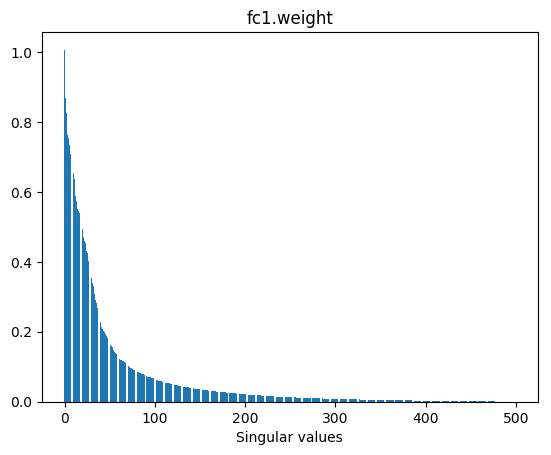

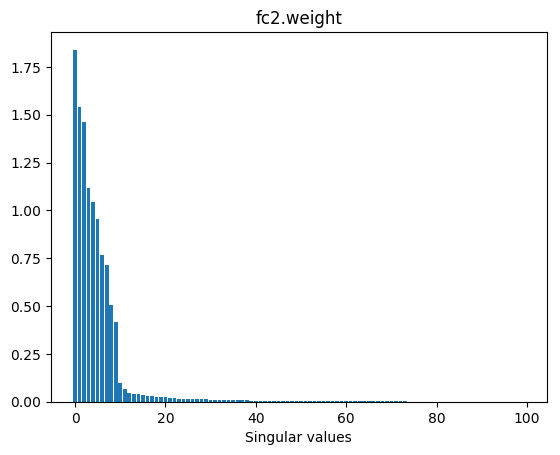

In [84]:
# plot the spectra and save figures under the experiment folder

plot_svd_spectra(net, ['fc1.weight', 'fc2.weight'], expDir)


(50, 3072)
47
(100, 3072)
87
(500, 3072)
352
(1000, 3072)
598


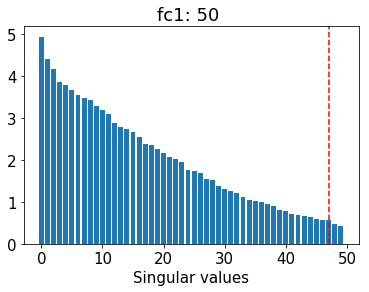

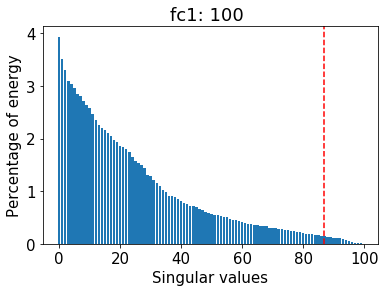

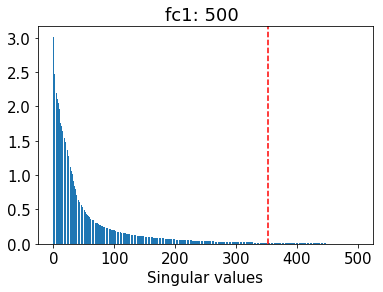

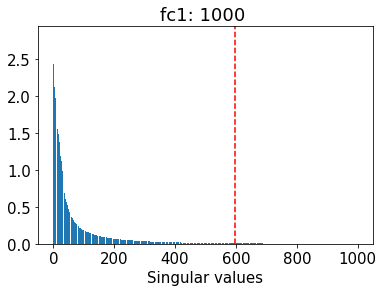

In [68]:

# MLP
fc1_wt = [50, 100, 500, 1000]
plt.rcParams.update({'font.size': 15})

for num_first_layer in fc1_wt:
    expName = 'cifar-mlp-v1_w1-%d' % num_first_layer
    w1 = num_first_layer # change conv1 dim
    w2 = 100
    expDir = os.path.join('./data', expName)
    SIMIL_THRESH = 0.9
    LAYER_CURR = 'fc1'
    LAYER_NEXT = 'fc2'
    batchSize = 1
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    
    plot_svd_spectra(net, ['fc1.weight'] , expDir)






In [66]:
# Save weight matrices of fc1 as MAT files to do CCA in MATLAB

from scipy import io

fc1_wt = [50, 100, 500, 1000]

for num_first_layer in fc1_wt:
    expName = 'cifar-mlp-v1_w1-%d' % num_first_layer
    w1 = num_first_layer # change conv1 dim
    w2 = 100
    expDir = os.path.join('./data', expName)
    SIMIL_THRESH = 0.9
    LAYER_CURR = 'fc1'
    LAYER_NEXT = 'fc2'
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    w1 = get_param(net, 'fc1.weight')
    w1 = w1.numpy()
    scipy.io.savemat(os.path.join(expDir,'w-fc1.mat'), dict(dat=w1))
    
    
    

In [71]:
# CNN filters into MATLAB

from scipy import io

conv1_wt = [50, 100, 500, 1000]

for num_first_layer in conv1_wt:
    expName = 'cifar-lenet-v1_w1-%d' % num_first_layer
    w1 = num_first_layer
    w2 = 50
    expDir = os.path.join('./data', expName)
    net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    w1 = get_param(net, 'conv1.weight')
    w1 = w1.numpy()
    scipy.io.savemat(os.path.join(expDir,'w-conv1.mat'), dict(dat=w1))
    
    
    

In [72]:
w1.shape

(1000, 3, 5, 5)

In [56]:
w1 = get_param(net, 'fc1.weight')
w1 = w1.numpy()

In [64]:

w1.shape
from scipy import io
scipy.io.savemat(os.path.join(expDir,'test.mat'), dict(dat=w1))

## Perturbations to network output

(500, 3072)
(100, 500)
(10, 100)
7.70228


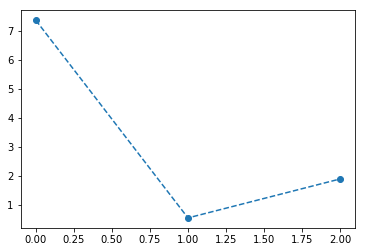

In [14]:

scale_net_params(net, LAYER_CURR, LAYER_NEXT)
layer_spectra = get_svd_spectra(net, ['fc1.weight', 'fc2.weight', 'fc3.weight'])
max_sigma = [x[0] for x in layer_spectra]
signal_gain = np.prod(max_sigma)
print signal_gain

plt.plot(max_sigma, 'o--')

After scaling:
1.35718


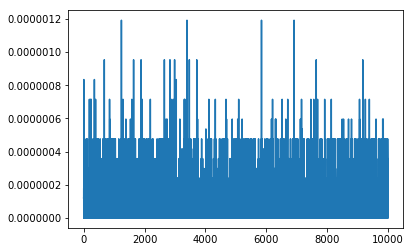

In [15]:
scaled_data_loss = get_dataset_loss(net, testloader)
scaled_data_loss = np.asarray(scaled_data_loss)
print 'After scaling:'
print np.mean(scaled_data_loss)

delta_scaled_output = np.absolute(scaled_data_loss - orig_data_loss)
plt.plot(delta_scaled_output, label='del output')

In [35]:
# Get Max perturbation in weights

cc_list, n_comps = get_filter_groups(net, LAYER_CURR, SIMIL_THRESH)

layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
filter_groups = [layer_curr_weights[torch.LongTensor(x)] \
                                    for x in cc_list]
filter_group_mean = [x.mean(dim=0) \
                                for x in filter_groups]
w_delta = get_sum_diff_filter_group(filter_groups, filter_group_mean)
max_w_delta = w_delta * signal_gain

print 'Delta W: %f' % w_delta
print 'Network gain: %f' % signal_gain
print 'Output Delta: %f' % max_w_delta

Delta W: 0.421887
Network gain: 7.702276
Output Delta: 3.249493


In [24]:
# reduced net data loss
reduce_similar_filters(net, LAYER_CURR, LAYER_NEXT, SIMIL_THRESH);
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
print np.mean(new_data_loss)


1.35991


In [25]:
# differences
delta_output = np.absolute(new_data_loss - orig_data_loss)

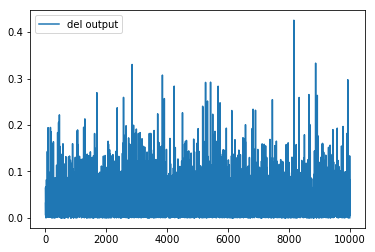

In [26]:
fig = plt.figure()
plt.plot(delta_output, label='del output')
plt.legend()

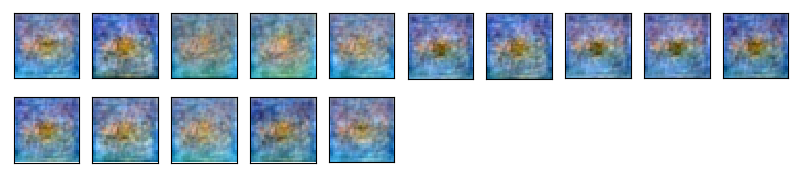

In [42]:
# sanity-check:
f = vis_linear_weights(filter_groups[10].numpy()) 

### Spectra for CNN 

In [ ]:
# specify settings
expName = 'cifar-lenet-v1_w1-500'
w1 = 500 # change conv1 dim
w2 = 50
expDir = os.path.join('./data', expName)

In [56]:
# for CNN
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net


NetWide (
  (conv1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


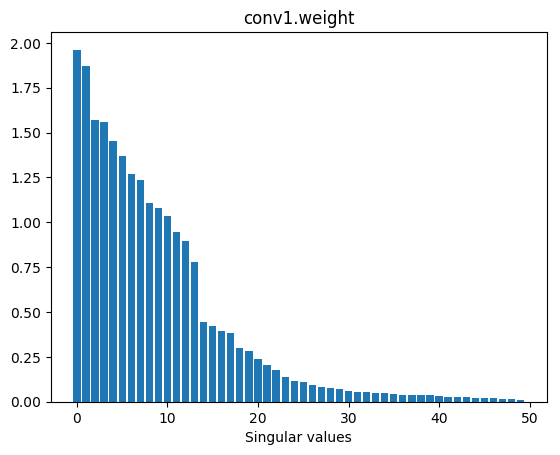

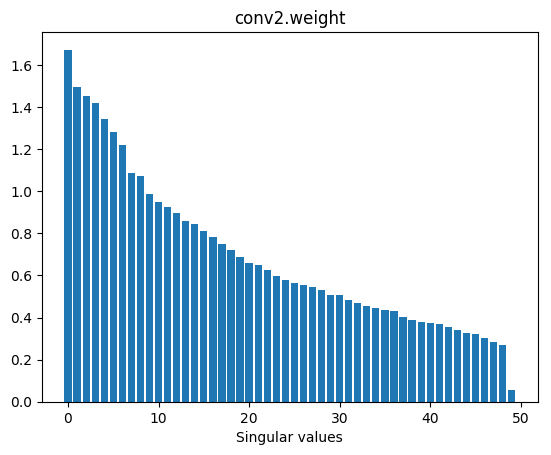

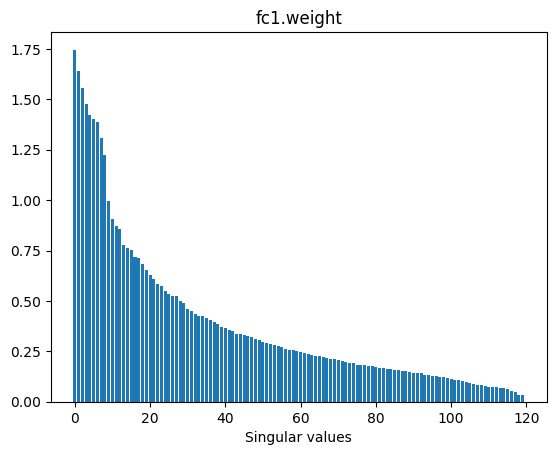

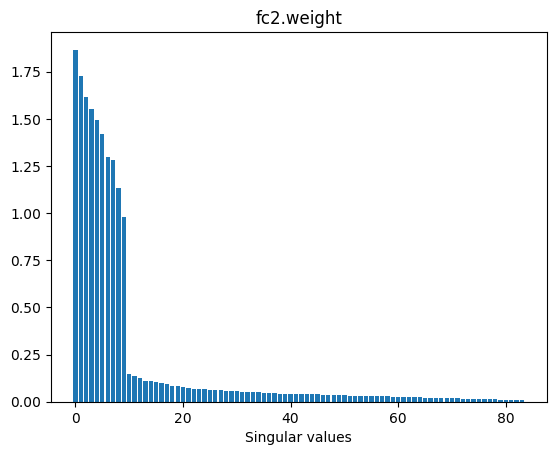

In [57]:
# plot the spectra and save figures under the experiment folder


plt.rcParams.update(plt.rcParamsDefault)
plot_svd_spectra(net, ['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight'], \
                 expDir)
